<a href="https://colab.research.google.com/github/larissavaladao/time_series_curuai/blob/main/5.%20parameters_by_period/3.area_spm_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd
import pandas as pd
import math
import ee
import geemap

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai2')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import image collections

12 imagens retiradas por ainda ter muita cobertura de nuvens e muitos 'buracos' por causa disso.

## mosaico por mes

In [ ]:
monthly_mosaics =  ee.ImageCollection('projects/ee-curuai2/assets/landsat_water_period/water_period')
display(monthly_mosaics.limit(2).getInfo())

{'type': 'ImageCollection',
 'bands': [],
 'version': 1741027115448792,
 'id': 'projects/ee-curuai2/assets/landsat_water_period/water_period',
 'features': [{'type': 'Image',
   'bands': [{'id': 'blue_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'green_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'red_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'nir_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
 

##mosaico por cota

13 imagens retiradas por excesso de cobertura de nuvens

In [94]:
water_mosaics =  ee.ImageCollection('projects/ee-curuai2/assets/landsat_water_period/water_period_discharge')
display(water_mosaics.limit(2).getInfo())

{'type': 'ImageCollection',
 'bands': [],
 'version': 1745520589917233,
 'id': 'projects/ee-curuai2/assets/landsat_water_period/water_period_discharge',
 'features': [{'type': 'Image',
   'bands': [{'id': 'blue_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'green_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'red_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'nir_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -2

# Get mean SPM value per image

In [95]:
def spm_stat_calc(img):
  '''receives a masked SPM classified image of curuai and returns mean SPM within the floodplain limits
  as a property of the input image'''


  floodplain = ee.FeatureCollection('projects/ee-curuai2/assets/varzea_alagavel')


  stats = img.select("classification").reduceRegion(**{
    'reducer': ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(), sharedInputs=True).combine(
    reducer2=ee.Reducer.max(), sharedInputs=True).combine(
    reducer2=ee.Reducer.min(), sharedInputs=True),
    'geometry': floodplain.geometry(),
    'scale': 30,
    'maxPixels': 1e10
    })

  return img.set({'mean_SPM':stats.get('classification_mean'),
                  'max_SPM':stats.get('classification_max'),
                  'min_SPM':stats.get('classification_min'),
                  'stdDev_SPM':stats.get('classification_stdDev')})

## por mes

In [ ]:
spm_classified_stat = monthly_mosaics.map(spm_stat_calc)
display(spm_classified_stat.size().getInfo())

88

## por cota

In [96]:
spm_cota_stat = water_mosaics.map(spm_stat_calc)
display(spm_cota_stat.size().getInfo())

86

#transform to dataframe por cota

In [97]:
dfArea = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(spm_cota_stat.map(lambda img: ee.Feature(None,img.toDictionary()))),
    'fileFormat': 'PANDAS_DATAFRAME'
})

# dfArea['time_start'] = pd.to_datetime(dfArea['time_start'])
# dfArea['month'] = dfArea['time_start'].dt.month
# dfArea['year'] = dfArea['time_start'].dt.year
# dfArea['day'] = dfArea['time_start'].dt.day

dfArea

,geo,area_km2,band_count,max_SPM,mean_SPM,min_SPM,month_end,month_init,stdDev_SPM,time_finish,time_start,year
0,None,988.055823,6,306.049042,73.779074,6.644032,2,1,52.140711,2000-02-29,2000-01-13,2000
1,None,1343.545142,6,255.054337,20.859879,5.296957,8,2,15.593235,2000-08-24,2000-02-29,2000
2,None,983.227657,6,306.049042,134.038118,8.780909,1,9,74.673074,2001-01-05,2000-09-28,2000
3,None,953.874670,6,306.049042,114.035651,6.311969,2,1,75.574448,2001-02-14,2001-01-05,2001
4,None,1398.929985,6,282.490112,20.702567,5.342866,8,2,20.977717,2001-08-05,2001-02-14,2001
...,...,...,...,...,...,...,...,...,...,...,...,...
81,None,1428.350797,6,298.301147,26.464622,5.801264,8,8,12.778907,2023-08-25,2023-08-01,2023
82,None,719.108947,6,306.049042,143.335259,6.060712,1,8,80.919941,2024-01-26,2023-08-25,2023
83,None,1066.777140,6,306.049042,35.994922,5.663524,3,1,20.554607,2024-03-25,2024-01-26,2024
84,None,1185.061555,6,282.490112,38.188542,5.510151,5,4,23.110245,2024-05-30,2024-04-06,2024


In [98]:
#import period dates
df_period_limits = pd.read_csv('/content/drive/MyDrive/CURUAI_PROCESS/water_period_limits.csv').drop(columns=['Unnamed: 0'])

df_period_limits['date'] = df_period_limits['Data'].apply(lambda x : x[0:10])
df_period_limits

,Data,type,day,month,year,longitude,latitude,date
0,2000-01-13 10:43:38.181818240,LW_to_R,13,1,2000,-55.5131,-1.9192,2000-01-13
1,2000-02-29 18:17:42.295081984,R_to_HW,29,2,2000,-55.5131,-1.9192,2000-02-29
2,2000-08-24 20:45:42.857142784,HW_to_F,24,8,2000,-55.5131,-1.9192,2000-08-24
3,2000-09-28 10:23:44.598930432,F_to_LW,28,9,2000,-55.5131,-1.9192,2000-09-28
4,2001-01-05 16:27:54.418604672,LW_to_R,5,1,2001,-55.5131,-1.9192,2001-01-05
...,...,...,...,...,...,...,...,...
95,2023-08-25 18:37:31.737451520,F_to_LW,25,8,2023,-55.5131,-1.9192,2023-08-25
96,2024-01-26 18:57:28.739495680,LW_to_R,26,1,2024,-55.5131,-1.9192,2024-01-26
97,2024-03-25 23:32:02.330097152,R_to_HW,25,3,2024,-55.5131,-1.9192,2024-03-25
98,2024-04-06 10:42:51.428571648,HW_to_F,6,4,2024,-55.5131,-1.9192,2024-04-06


In [99]:
def set_period(row):
  return df_period_limits.loc[df_period_limits['date'] == row['time_start']]['type'].values[0]

dfArea['WATER_PERIOD'] = dfArea.apply(set_period,axis=1)

dfArea=dfArea.replace('LW_to_R', 'R')
dfArea=dfArea.replace('R_to_HW', 'HW')
dfArea=dfArea.replace('HW_to_F', 'F')
dfArea=dfArea.replace('F_to_LW', 'LW')
dfArea=dfArea.replace('F_to_L', 'LW')
dfArea

,geo,area_km2,band_count,max_SPM,mean_SPM,min_SPM,month_end,month_init,stdDev_SPM,time_finish,time_start,year,WATER_PERIOD
0,None,988.055823,6,306.049042,73.779074,6.644032,2,1,52.140711,2000-02-29,2000-01-13,2000,R
1,None,1343.545142,6,255.054337,20.859879,5.296957,8,2,15.593235,2000-08-24,2000-02-29,2000,HW
2,None,983.227657,6,306.049042,134.038118,8.780909,1,9,74.673074,2001-01-05,2000-09-28,2000,LW
3,None,953.874670,6,306.049042,114.035651,6.311969,2,1,75.574448,2001-02-14,2001-01-05,2001,R
4,None,1398.929985,6,282.490112,20.702567,5.342866,8,2,20.977717,2001-08-05,2001-02-14,2001,HW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,None,1428.350797,6,298.301147,26.464622,5.801264,8,8,12.778907,2023-08-25,2023-08-01,2023,F
82,None,719.108947,6,306.049042,143.335259,6.060712,1,8,80.919941,2024-01-26,2023-08-25,2023,LW
83,None,1066.777140,6,306.049042,35.994922,5.663524,3,1,20.554607,2024-03-25,2024-01-26,2024,R
84,None,1185.061555,6,282.490112,38.188542,5.510151,5,4,23.110245,2024-05-30,2024-04-06,2024,F


In [100]:
dfArea = dfArea[['area_km2','mean_SPM','max_SPM','min_SPM','stdDev_SPM',	'time_finish',	'time_start',	'year','WATER_PERIOD']].copy()

dfArea

,area_km2,mean_SPM,max_SPM,min_SPM,stdDev_SPM,time_finish,time_start,year,WATER_PERIOD
0,988.055823,73.779074,306.049042,6.644032,52.140711,2000-02-29,2000-01-13,2000,R
1,1343.545142,20.859879,255.054337,5.296957,15.593235,2000-08-24,2000-02-29,2000,HW
2,983.227657,134.038118,306.049042,8.780909,74.673074,2001-01-05,2000-09-28,2000,LW
3,953.874670,114.035651,306.049042,6.311969,75.574448,2001-02-14,2001-01-05,2001,R
4,1398.929985,20.702567,282.490112,5.342866,20.977717,2001-08-05,2001-02-14,2001,HW
...,...,...,...,...,...,...,...,...,...
81,1428.350797,26.464622,298.301147,5.801264,12.778907,2023-08-25,2023-08-01,2023,F
82,719.108947,143.335259,306.049042,6.060712,80.919941,2024-01-26,2023-08-25,2023,LW
83,1066.777140,35.994922,306.049042,5.663524,20.554607,2024-03-25,2024-01-26,2024,R
84,1185.061555,38.188542,282.490112,5.510151,23.110245,2024-05-30,2024-04-06,2024,F


#view time series por cota

## area vs time

<Axes: xlabel='time_start', ylabel='area_km2'>

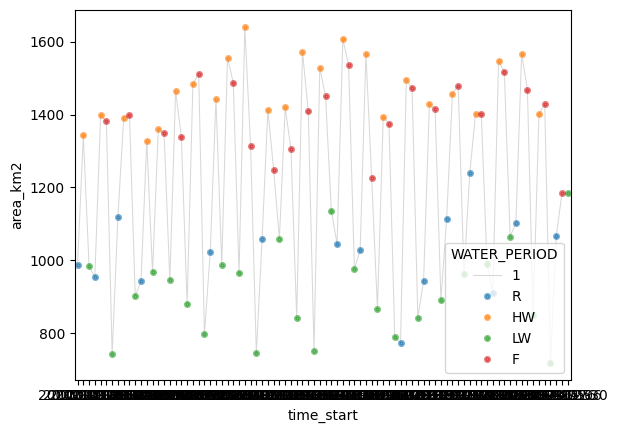

In [101]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='time_start',y= 'area_km2',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='time_start',y= 'area_km2',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

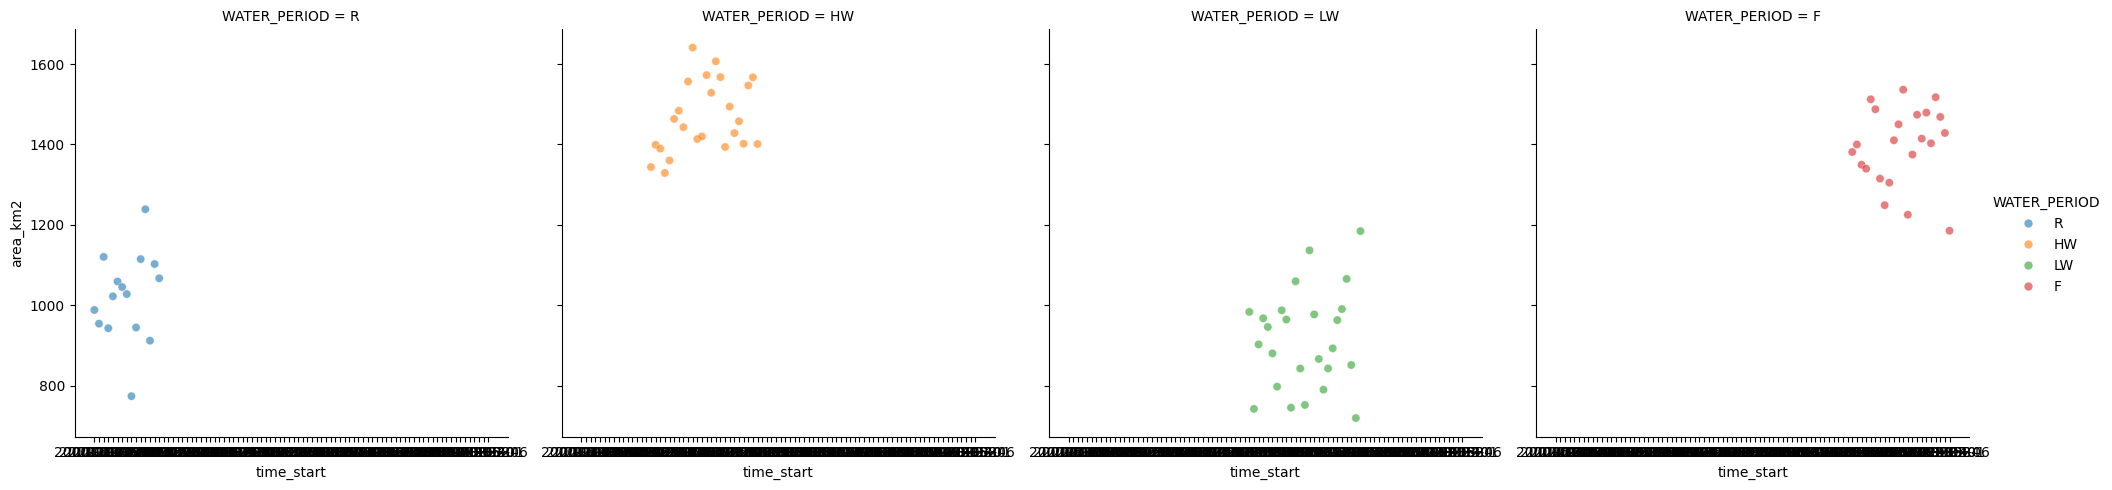

In [102]:

sns.relplot(data=dfArea, x ='time_start',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

## area vs spm

### mean spm

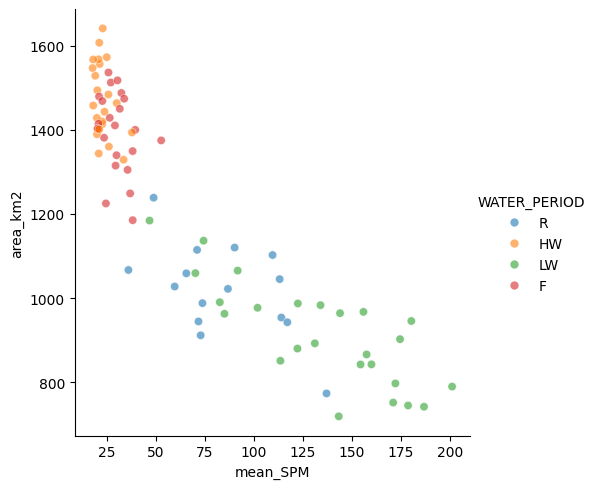

In [103]:
sns.relplot(data=dfArea, x ='mean_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

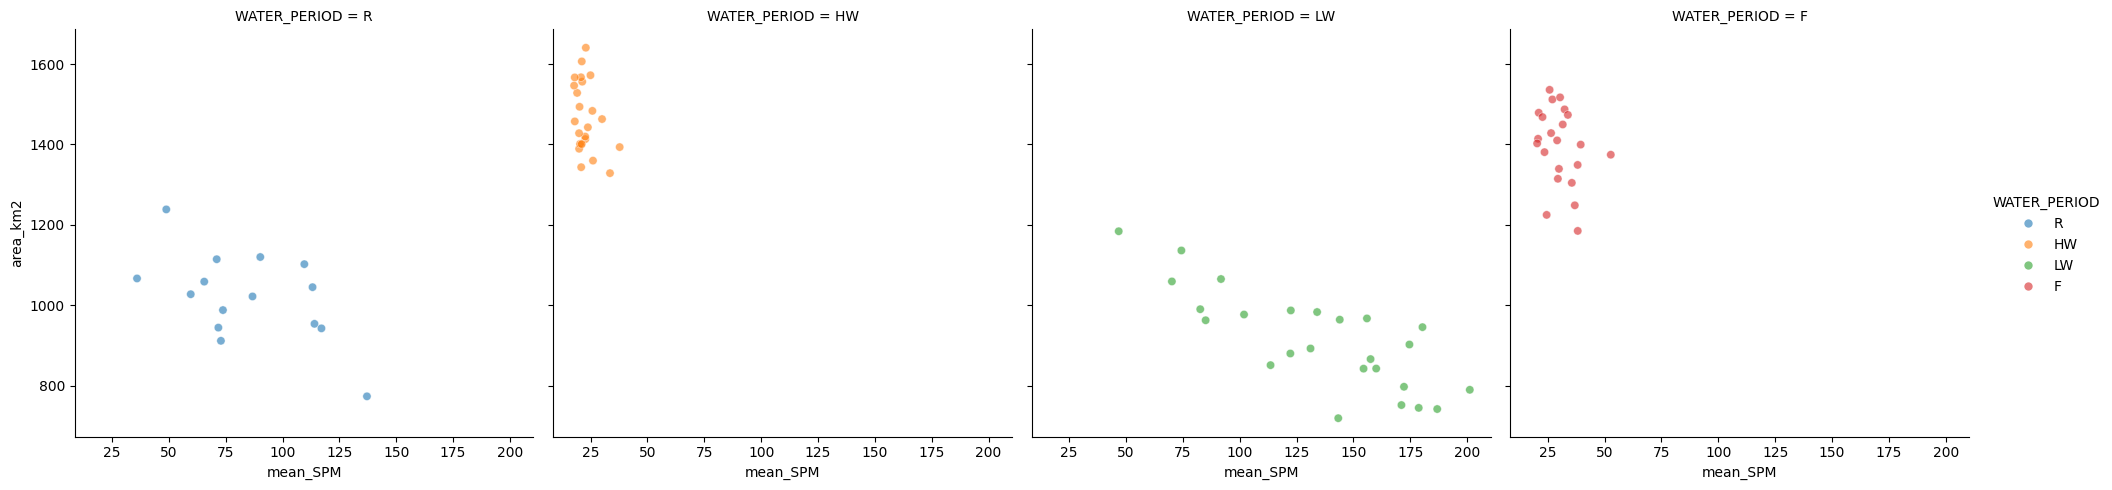

In [104]:
sns.relplot(data=dfArea, x ='mean_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### max spm

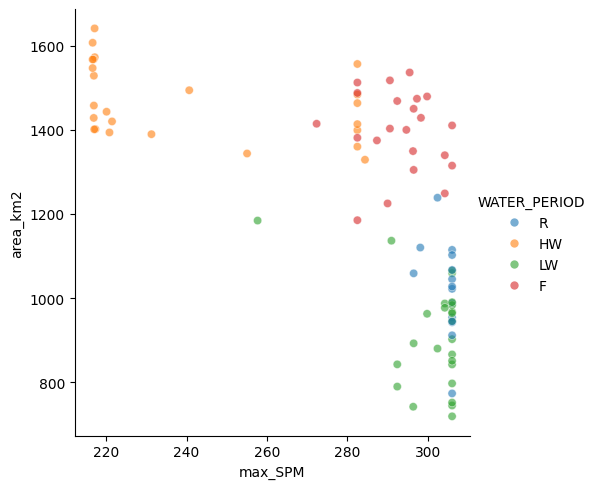

In [105]:
sns.relplot(data=dfArea, x ='max_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

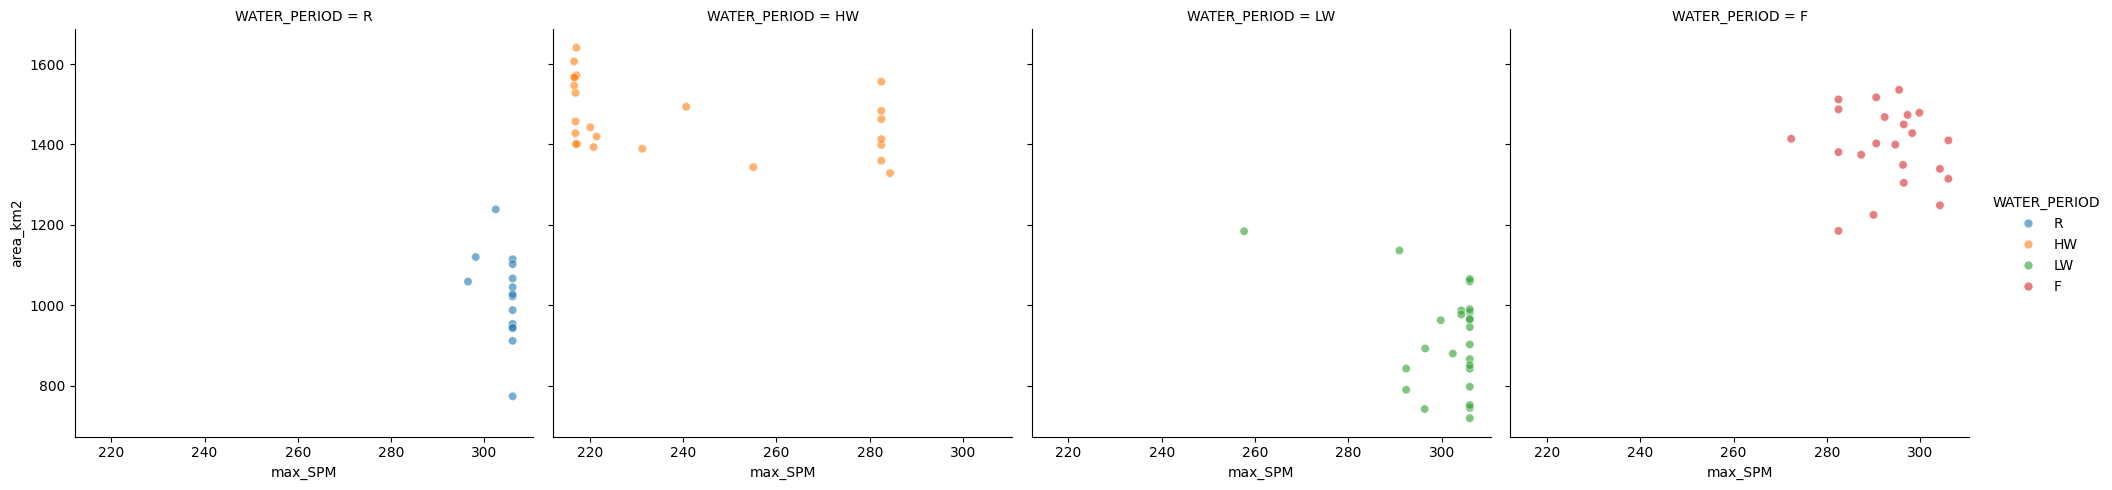

In [106]:
sns.relplot(data=dfArea, x ='max_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### min spm

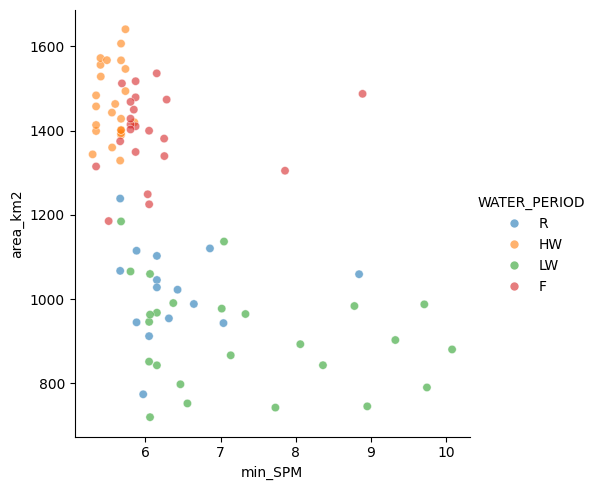

In [107]:
sns.relplot(data=dfArea, x ='min_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

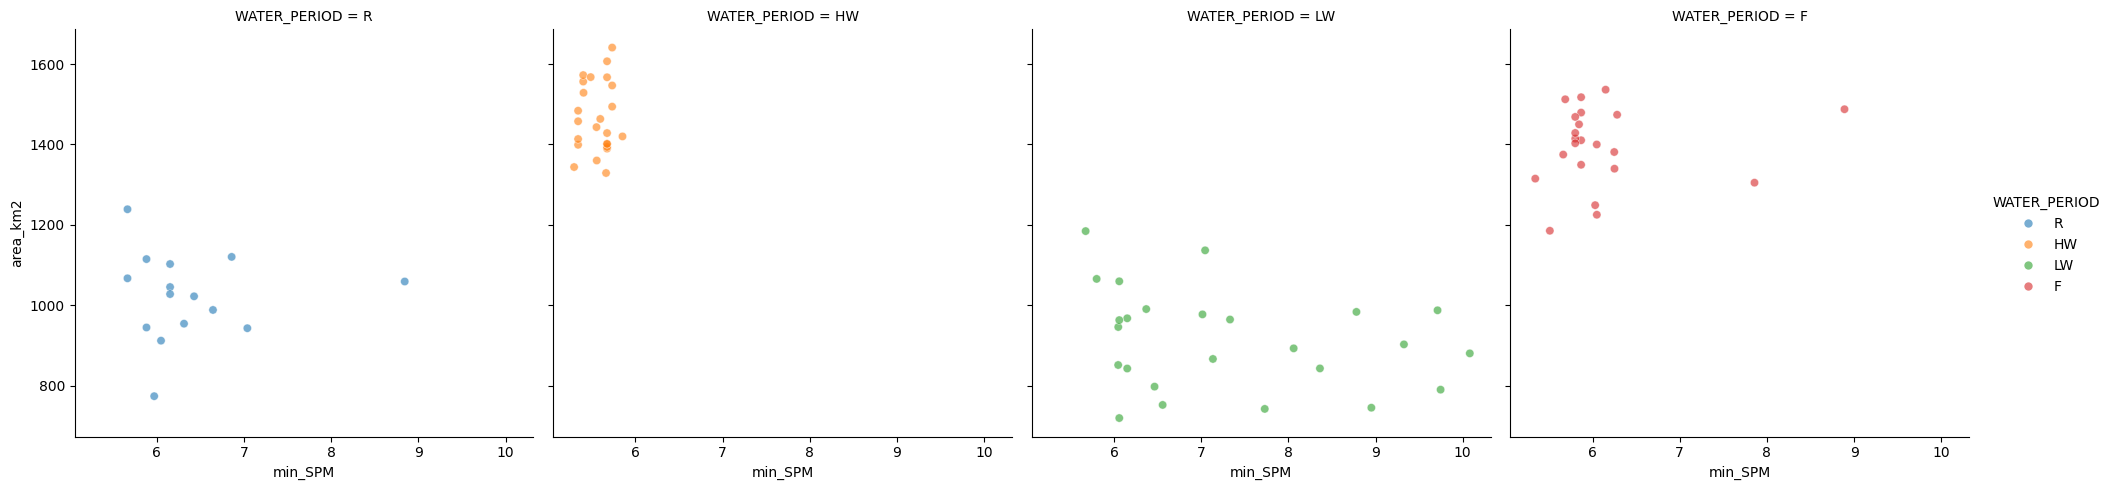

In [108]:
sns.relplot(data=dfArea, x ='min_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### std dev spm

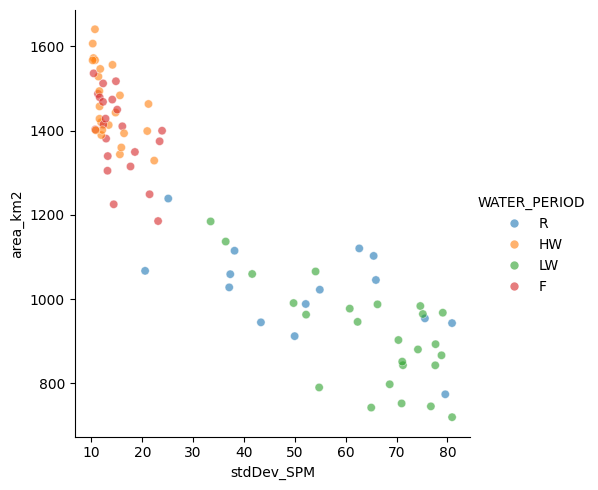

In [109]:
sns.relplot(data=dfArea, x ='stdDev_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

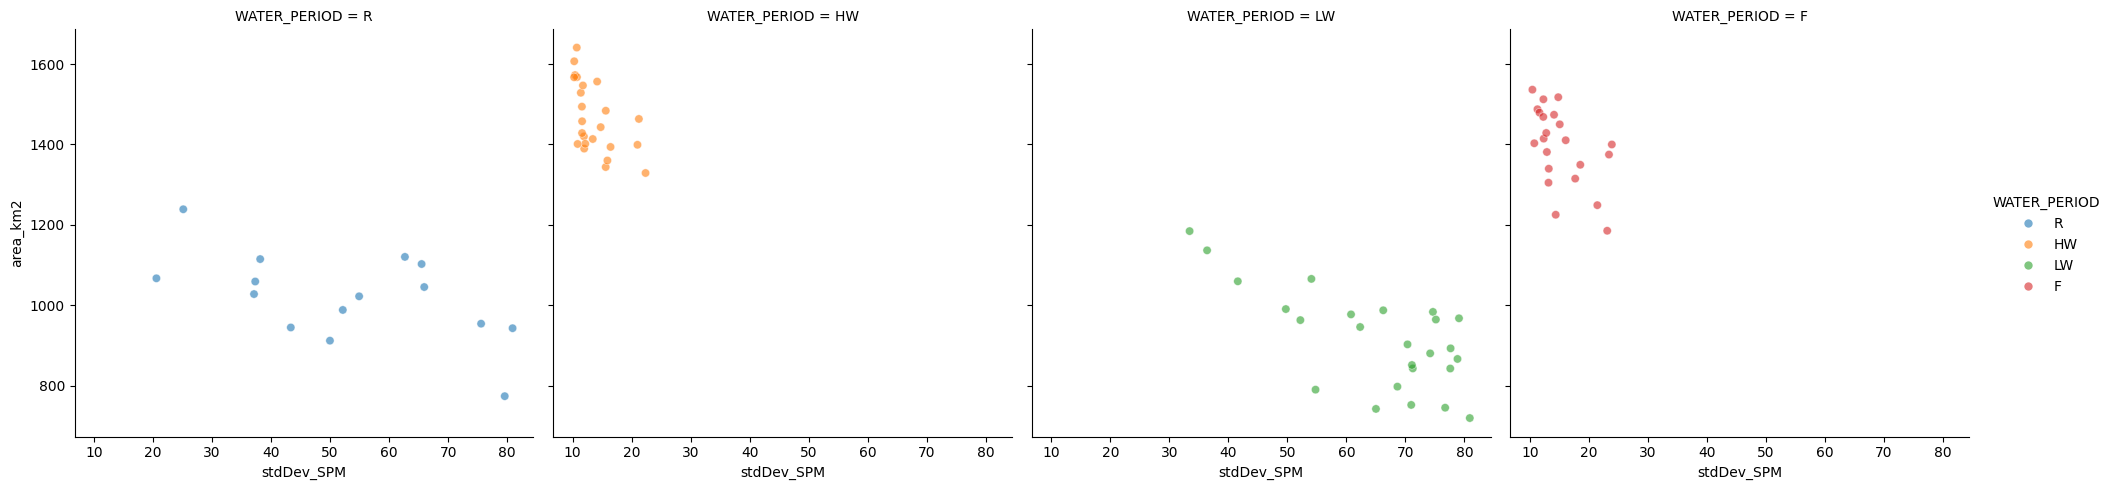

In [110]:
sns.relplot(data=dfArea, x ='stdDev_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

## spm vs time

### mean spm

<Axes: xlabel='time_start', ylabel='mean_SPM'>

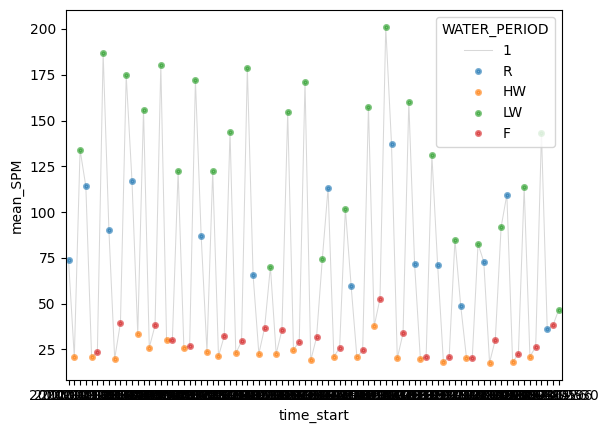

In [111]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='time_start',y= 'mean_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='time_start',y= 'mean_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

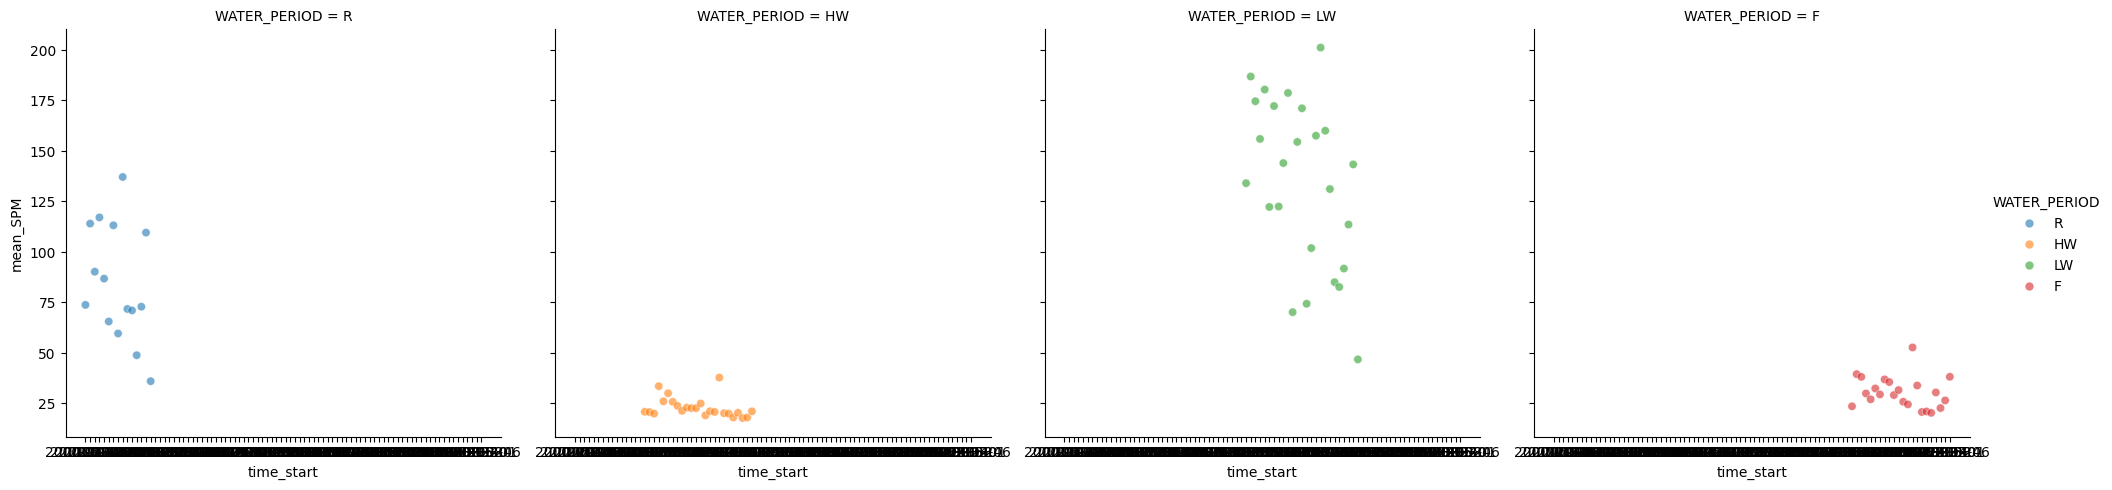

In [112]:
sns.relplot(data=dfArea, x ='time_start',y= 'mean_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### max spm

<Axes: xlabel='time_start', ylabel='max_SPM'>

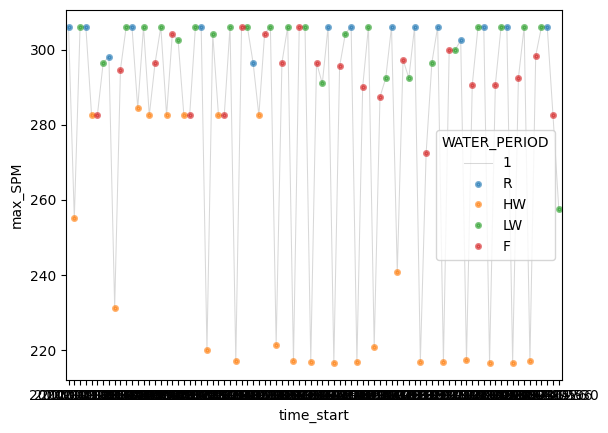

In [113]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='time_start',y= 'max_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='time_start',y= 'max_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

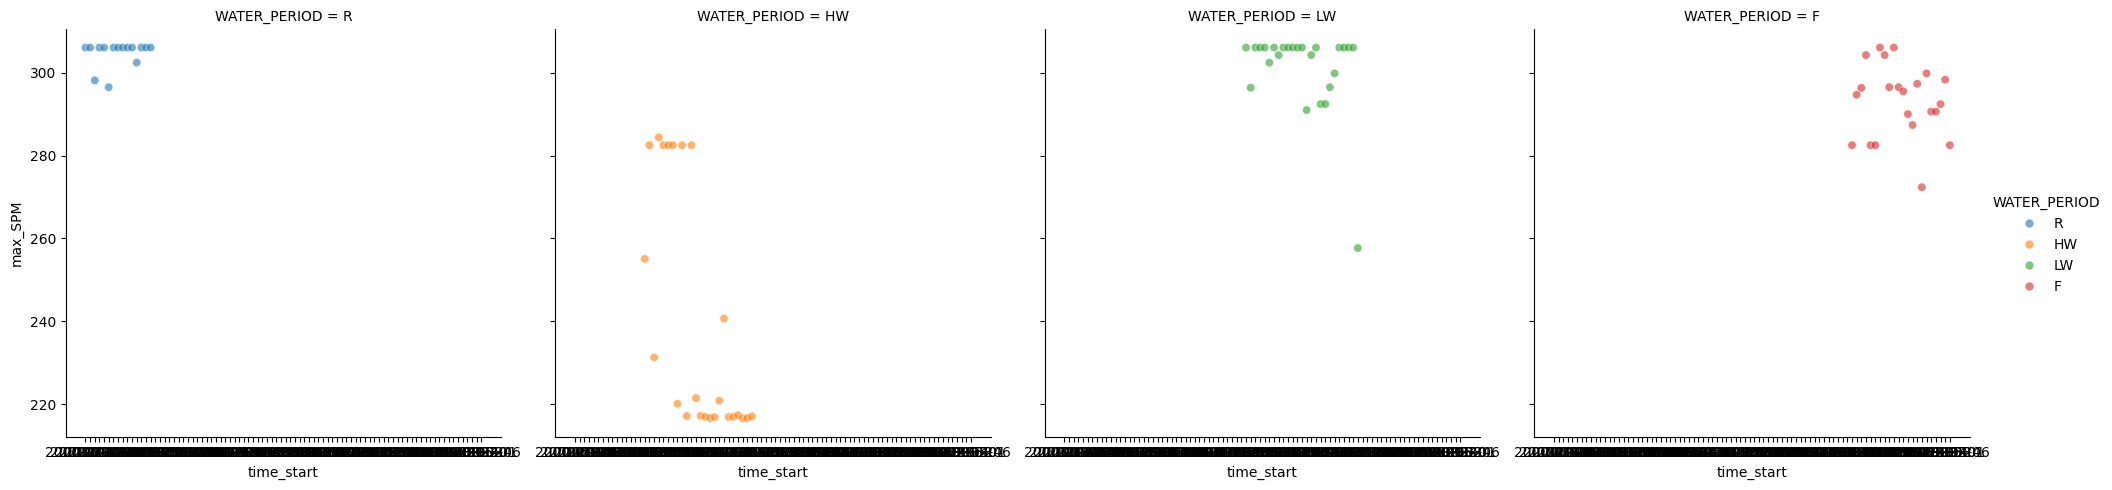

In [114]:
sns.relplot(data=dfArea, x ='time_start',y= 'max_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### min spm

<Axes: xlabel='time_start', ylabel='min_SPM'>

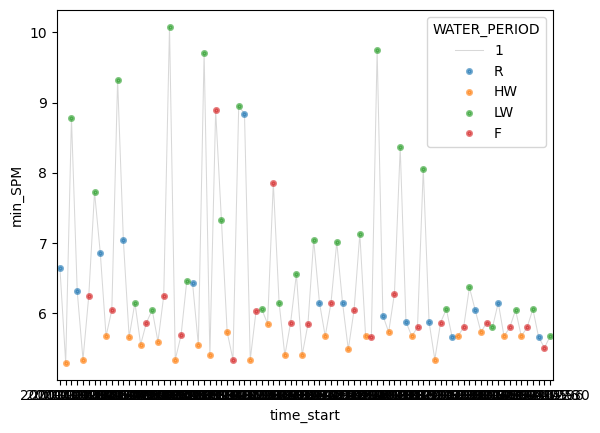

In [115]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='time_start',y= 'min_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='time_start',y= 'min_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

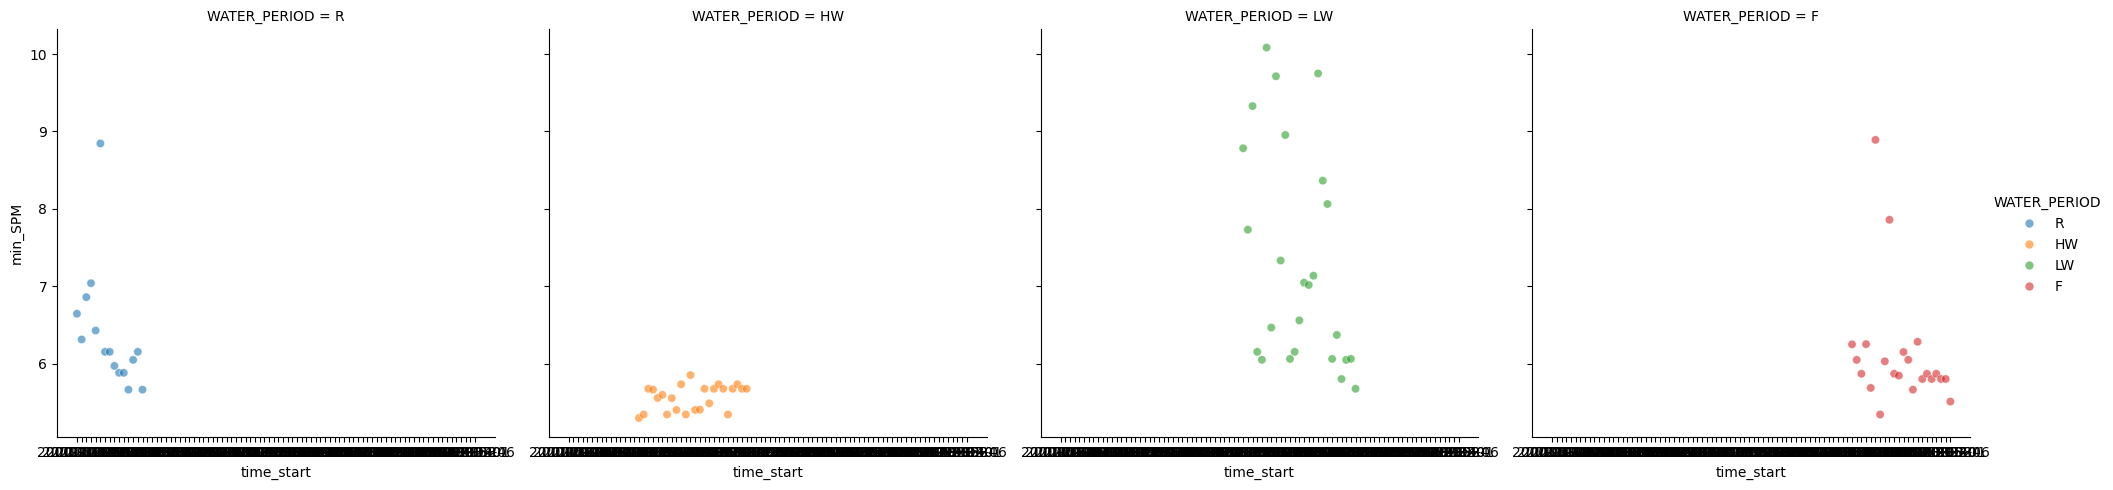

In [116]:
sns.relplot(data=dfArea, x ='time_start',y= 'min_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### std dev spm

<Axes: xlabel='time_start', ylabel='stdDev_SPM'>

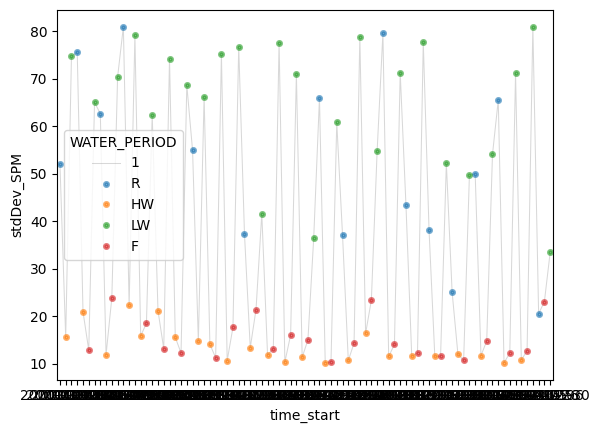

In [117]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='time_start',y= 'stdDev_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='time_start',y= 'stdDev_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

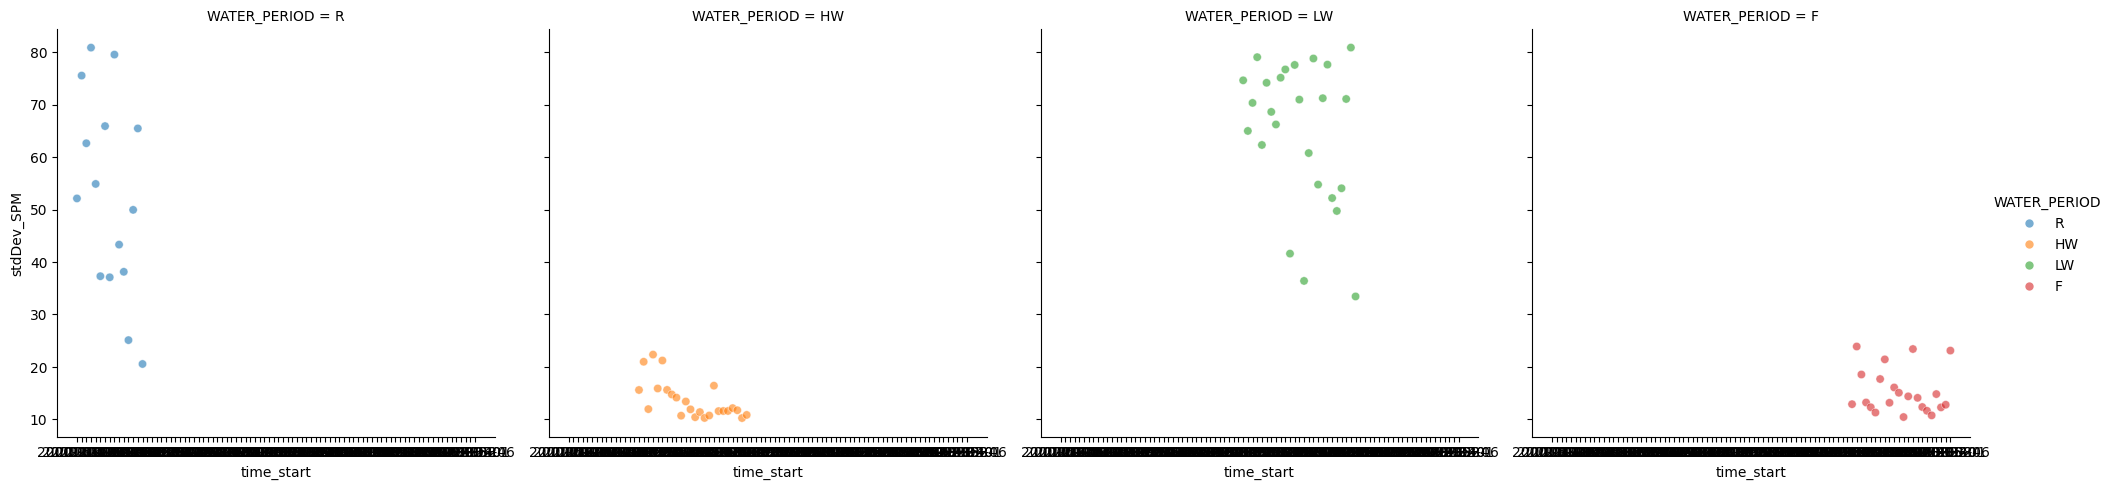

In [118]:
sns.relplot(data=dfArea, x ='time_start',y= 'stdDev_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

# Data vizualization

In [120]:
dfArea.describe()

,area_km2,mean_SPM,max_SPM,min_SPM,stdDev_SPM
count,86.000000,86.000000,86.000000,86.000000,86.000000
mean,1209.993005,67.944486,282.570322,6.354236,35.762204
std,265.168652,54.120576,31.938382,1.134194,25.860464
min,719.108947,17.742509,216.640869,5.296957,10.238238
25%,969.748556,23.625416,282.490112,5.674996,12.805529
50%,1276.685344,37.967784,296.486359,5.925680,21.891010
75%,1428.287635,112.282847,306.049042,6.412925,62.584300
max,1640.763275,201.184570,306.049042,10.081149,80.919941


<Axes: >

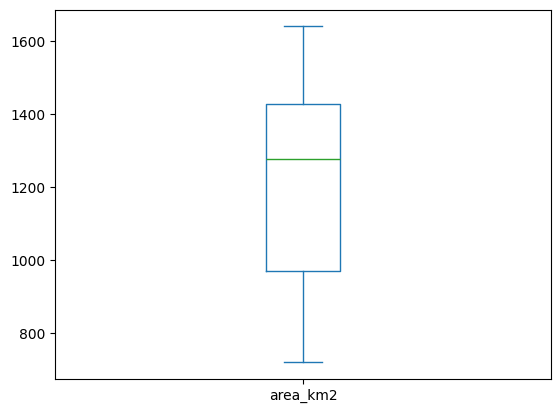

In [121]:
dfArea['area_km2'].plot.box()

<Axes: >

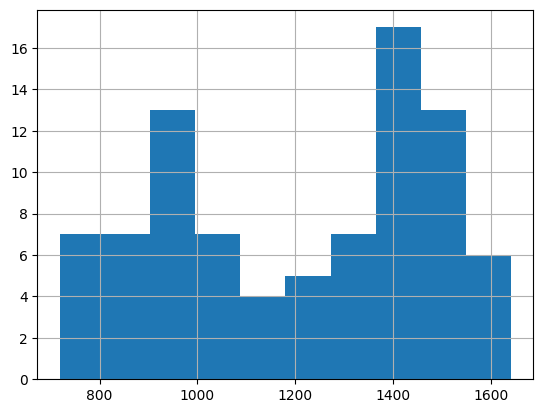

In [122]:
dfArea['area_km2'].hist()

<Axes: >

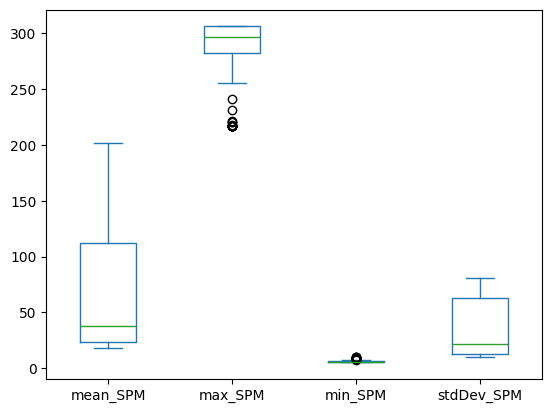

In [123]:
dfArea[['mean_SPM','max_SPM','min_SPM','stdDev_SPM']].plot.box()

array([[<Axes: title={'center': 'mean_SPM'}>,
        <Axes: title={'center': 'max_SPM'}>],
       [<Axes: title={'center': 'min_SPM'}>,
        <Axes: title={'center': 'stdDev_SPM'}>]], dtype=object)

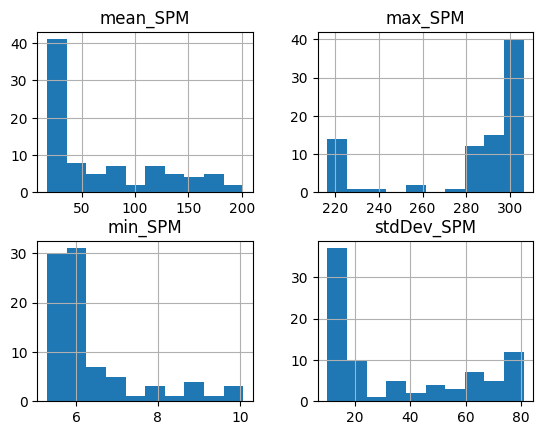

In [124]:
dfArea[['mean_SPM','max_SPM','min_SPM','stdDev_SPM']].hist()

##Export results

In [125]:
#export table results
dfArea.to_csv('/content/drive/MyDrive/CURUAI_PROCESS/area_SPM_time_series_cota.csv')

#transform to dataframe por mes

In [8]:
dfArea = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(spm_classified_stat.map(lambda img: ee.Feature(None,img.toDictionary()))),
    'fileFormat': 'PANDAS_DATAFRAME'
})
dfArea

,geo,area_km2,band_count,max_SPM,mean_SPM,min_SPM,month_end,month_init,stdDev_SPM,time_finish,time_start,year
0,None,988.055823,6,306.049042,73.779074,6.644032,2,1,52.140711,2000-02-29,2000-01-13,2000
1,None,1343.545142,6,255.054337,20.859879,5.296957,8,2,15.593235,2000-08-24,2000-02-29,2000
2,None,983.227657,6,306.049042,134.038118,8.780909,1,9,74.673074,2001-01-05,2000-09-28,2000
3,None,953.874670,6,306.049042,114.035651,6.311969,2,1,75.574448,2001-02-14,2001-01-05,2001
4,None,1398.929985,6,282.490112,20.702567,5.342866,8,2,20.977717,2001-08-05,2001-02-14,2001
...,...,...,...,...,...,...,...,...,...,...,...,...
84,None,719.108947,6,306.049042,143.335259,6.060712,1,8,80.919941,2024-01-26,2023-08-25,2023
85,None,1066.777140,6,306.049042,35.994922,5.663524,3,1,20.554607,2024-03-25,2024-01-26,2024
86,None,1082.838632,6,304.234253,45.593203,5.972806,4,3,22.119043,2024-04-06,2024-03-25,2024
87,None,1185.061555,6,282.490112,38.188542,5.510151,5,4,23.110245,2024-05-30,2024-04-06,2024


In [ ]:
def return_period(month):
  if month == 1:
    return 'R'
  elif month == 4:
    return 'HW'
  elif month == 7:
    return 'F'
  elif month == 10:
    return 'LW'
  else:
    return 'U'

In [ ]:
dfArea = dfArea[['area_km2','mean_SPM','max_SPM','min_SPM','stdDev_SPM',	'month_end',	'month_init',	'timestamp',	'year',]].copy()
dfArea['WATER_PERIOD'] = dfArea.apply(lambda row: return_period(row['month_init']),axis = 1)
dfArea

,area_km2,mean_SPM,max_SPM,min_SPM,stdDev_SPM,month_end,month_init,timestamp,year,WATER_PERIOD
0,989.084758,73.535345,306.049042,6.644032,51.890127,3,1,2000-01-01,2000,R
1,1335.446135,22.679618,282.490112,5.844900,15.929416,9,7,2000-07-01,2000,F
2,983.227657,134.038118,306.049042,8.780909,74.673074,12,10,2000-10-01,2000,LW
3,1134.171724,93.210925,306.049042,6.623919,65.276331,3,1,2001-01-01,2001,R
4,1335.085554,18.724521,282.490112,5.401382,15.715166,6,4,2001-04-01,2001,HW
...,...,...,...,...,...,...,...,...,...,...
83,463.786451,208.968305,306.049042,6.781344,61.418259,12,10,2023-10-01,2023,LW
84,949.024621,36.722792,306.049042,5.868872,20.214386,3,1,2024-01-01,2024,R
85,1296.697903,32.580176,282.490112,5.754973,18.713887,6,4,2024-04-01,2024,HW
86,1268.924408,39.458892,226.239838,5.868872,12.820446,9,7,2024-07-01,2024,F


#view time series

## area vs time

<Axes: xlabel='timestamp', ylabel='area_km2'>

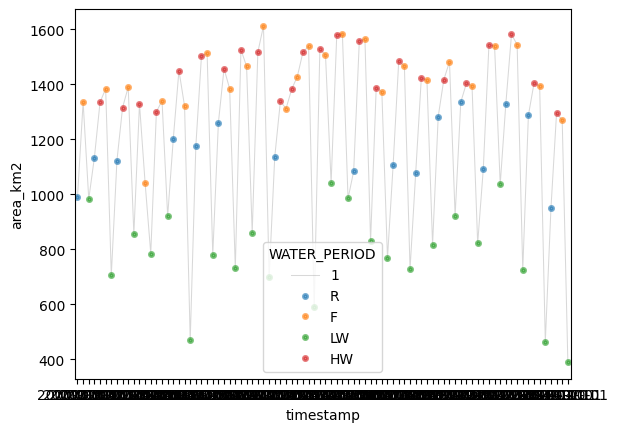

In [ ]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'area_km2',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'area_km2',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

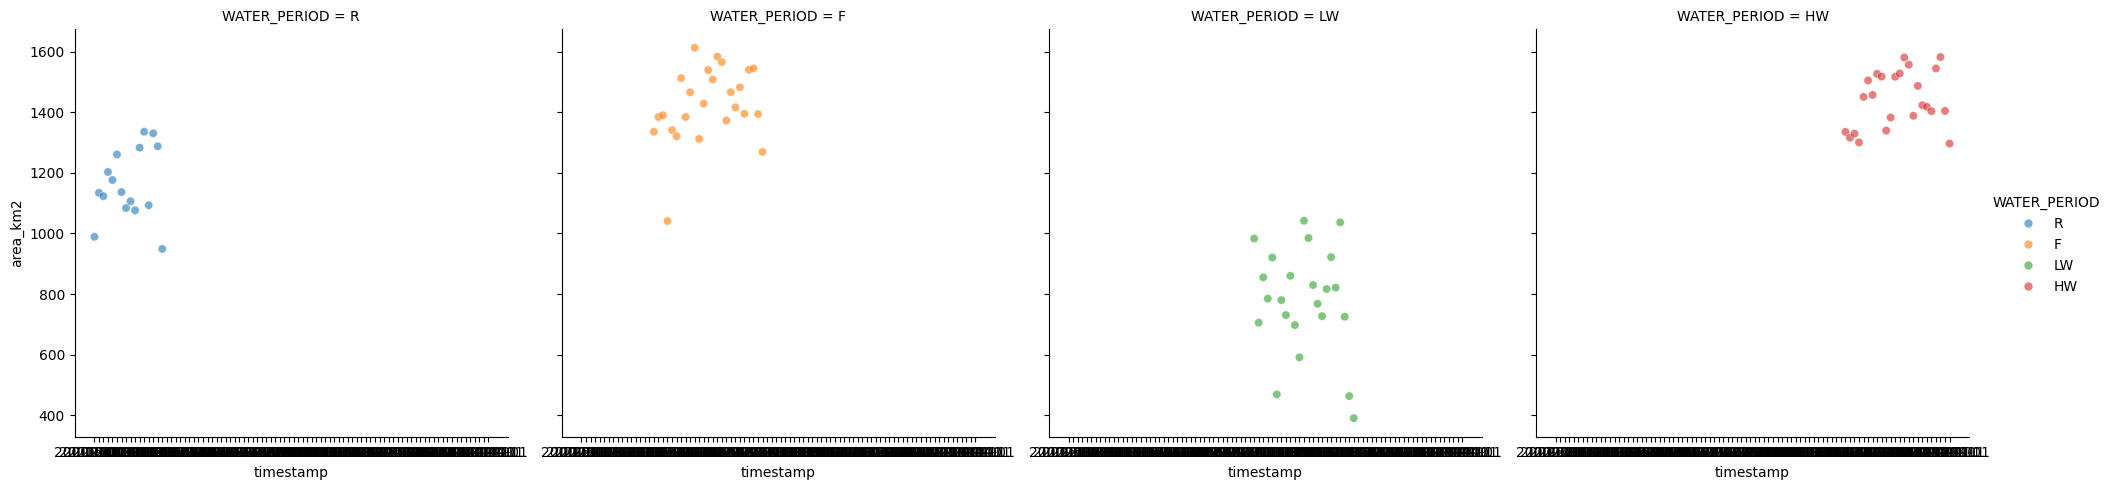

In [ ]:

sns.relplot(data=dfArea, x ='timestamp',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

## area vs spm

### mean spm

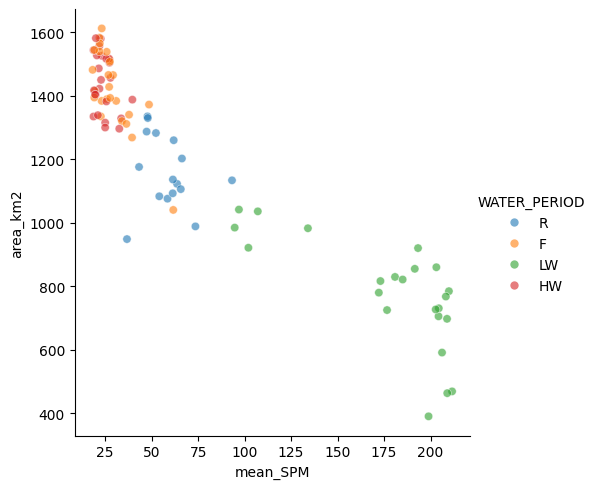

In [ ]:
sns.relplot(data=dfArea, x ='mean_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

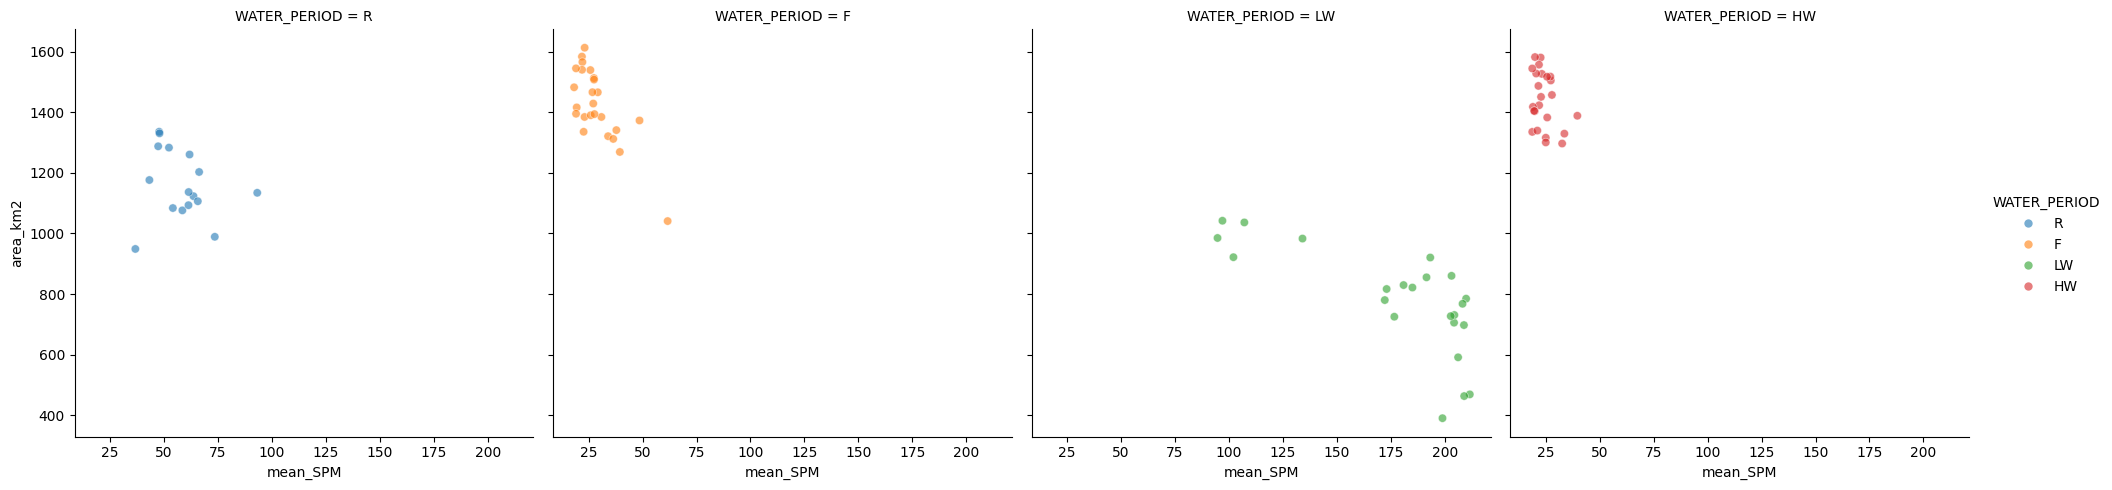

In [ ]:
sns.relplot(data=dfArea, x ='mean_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### max spm

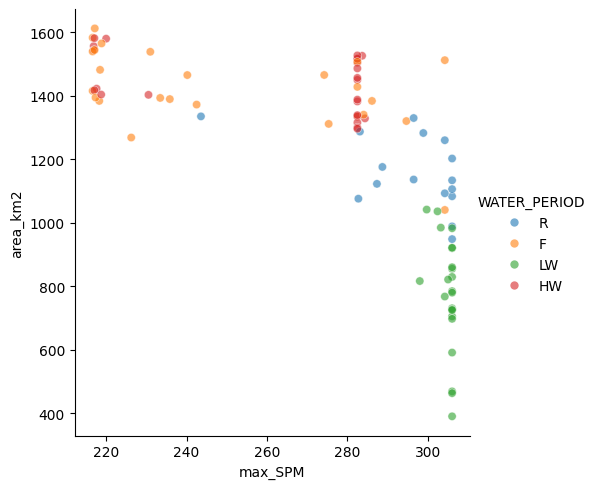

In [ ]:
sns.relplot(data=dfArea, x ='max_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

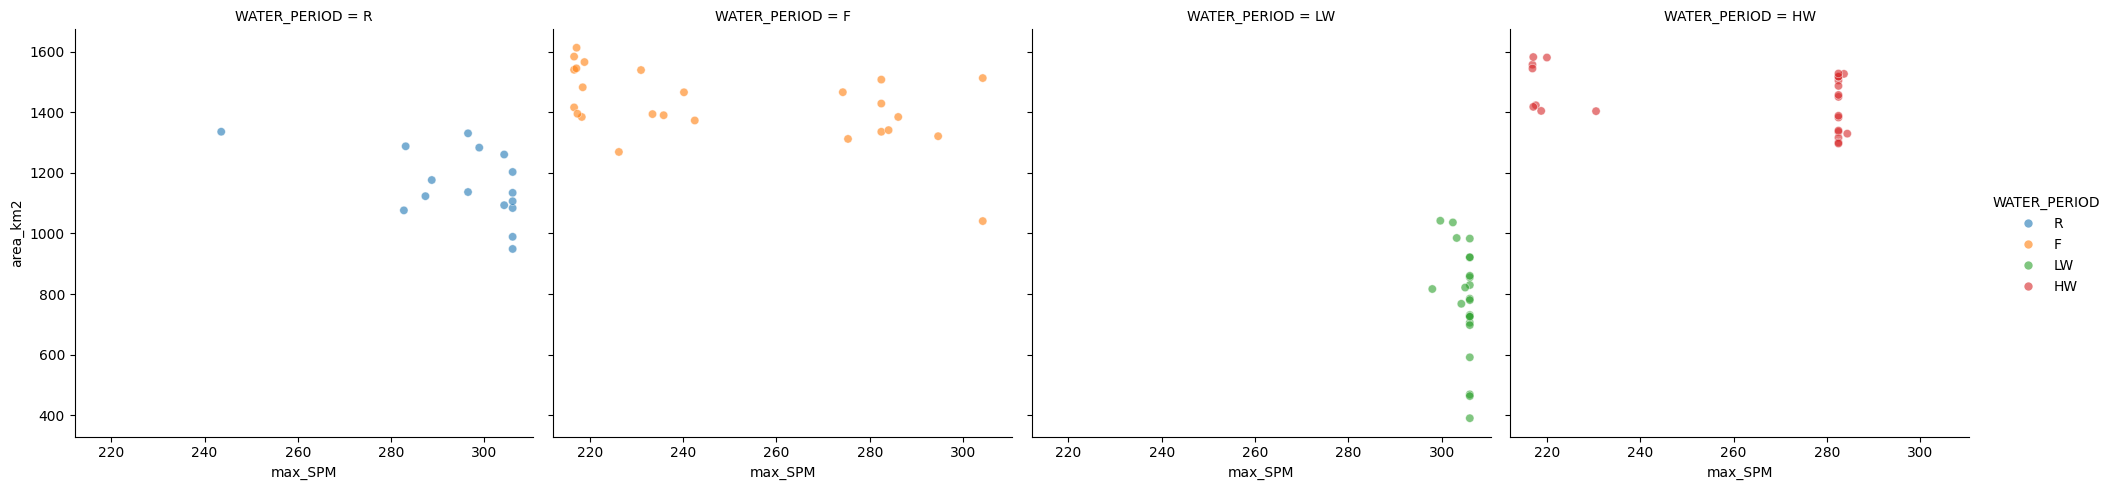

In [ ]:
sns.relplot(data=dfArea, x ='max_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### min spm

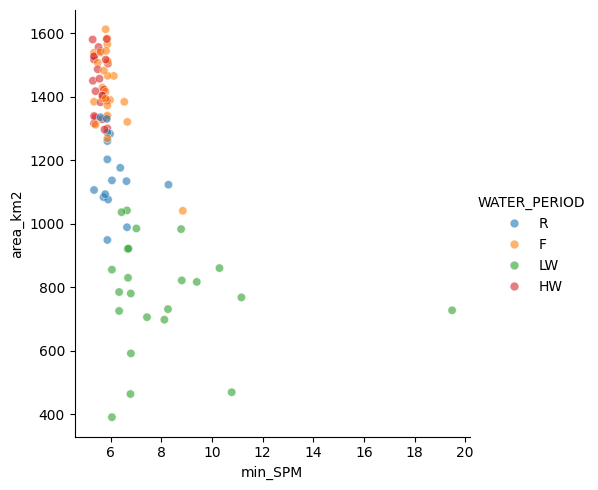

In [ ]:
sns.relplot(data=dfArea, x ='min_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

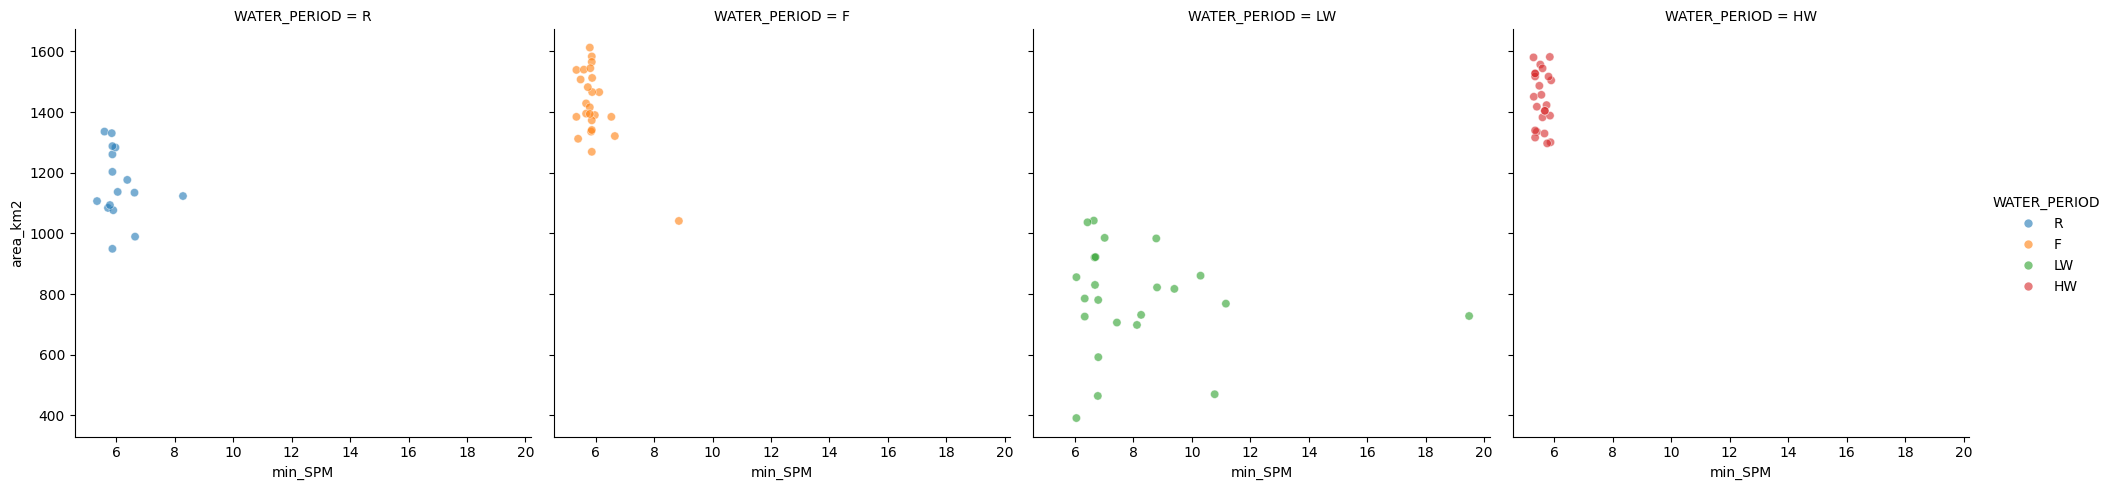

In [ ]:
sns.relplot(data=dfArea, x ='min_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### std dev spm

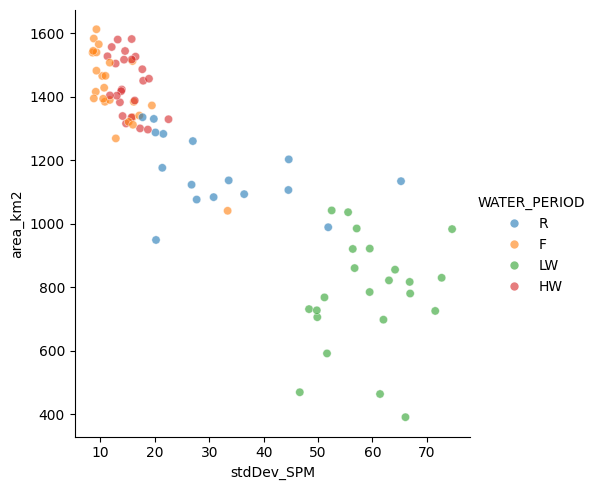

In [ ]:
sns.relplot(data=dfArea, x ='stdDev_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

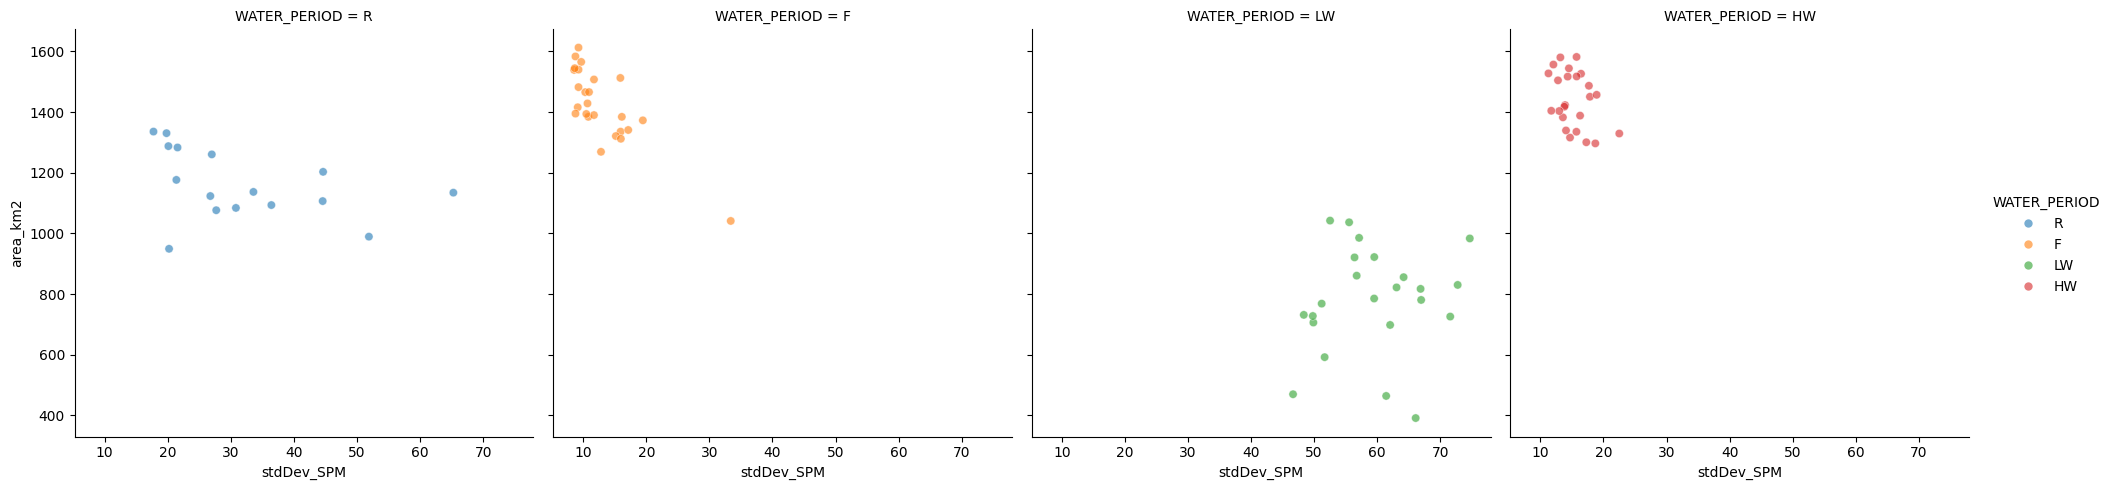

In [ ]:
sns.relplot(data=dfArea, x ='stdDev_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

## spm vs time

### mean spm

<Axes: xlabel='timestamp', ylabel='mean_SPM'>

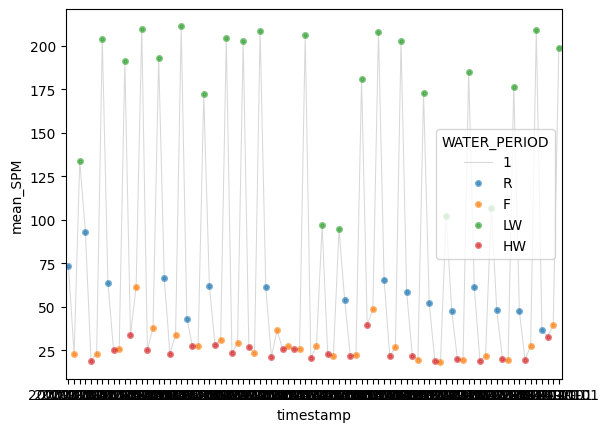

In [ ]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'mean_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'mean_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

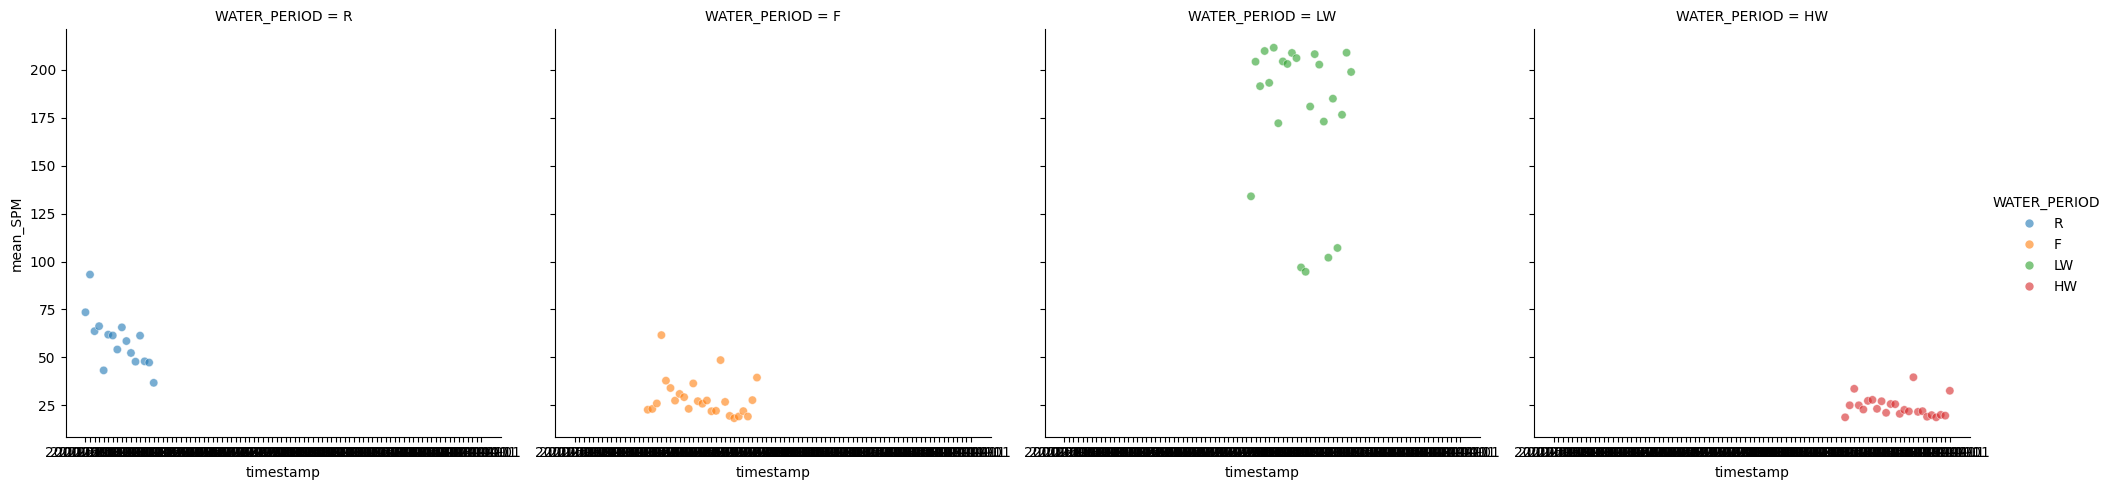

In [ ]:
sns.relplot(data=dfArea, x ='timestamp',y= 'mean_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### max spm

<Axes: xlabel='timestamp', ylabel='max_SPM'>

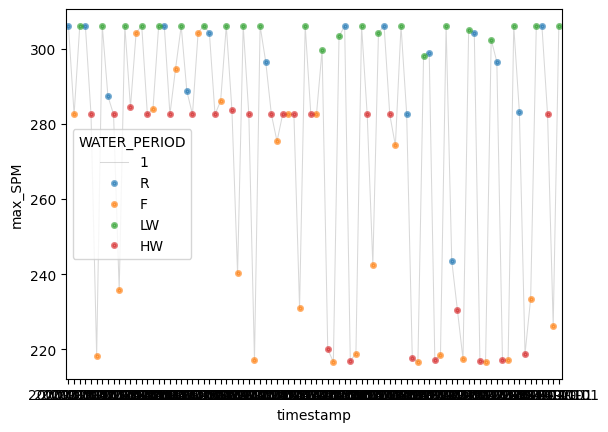

In [ ]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'max_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'max_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

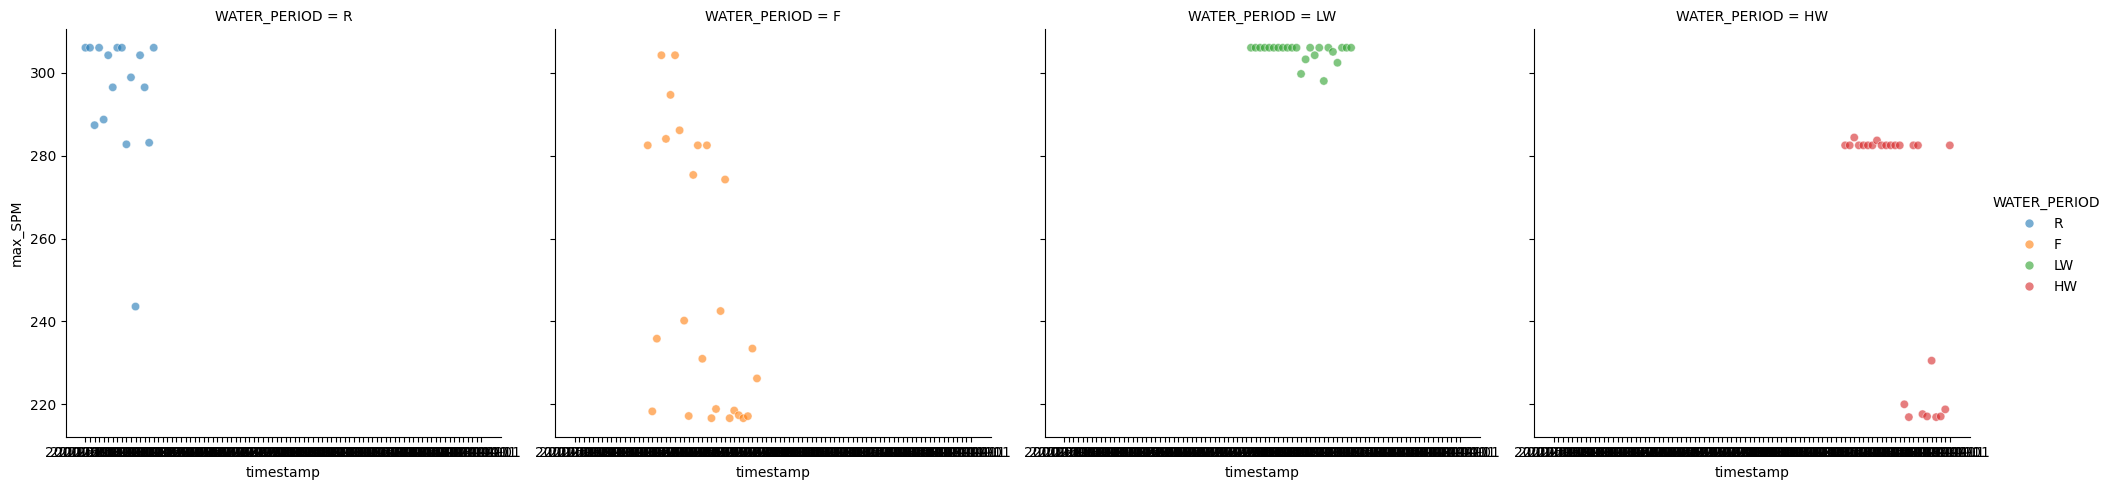

In [ ]:
sns.relplot(data=dfArea, x ='timestamp',y= 'max_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### min spm

<Axes: xlabel='timestamp', ylabel='min_SPM'>

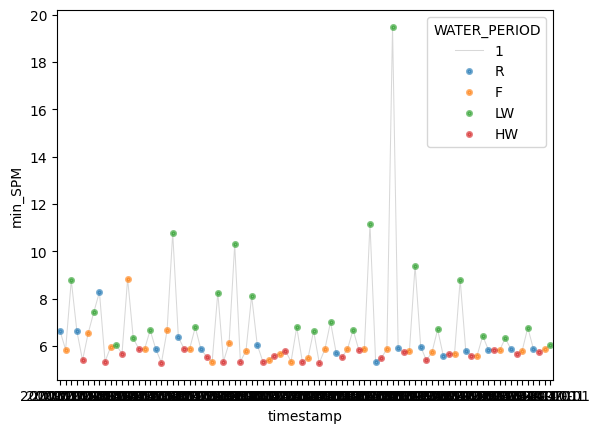

In [ ]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'min_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'min_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

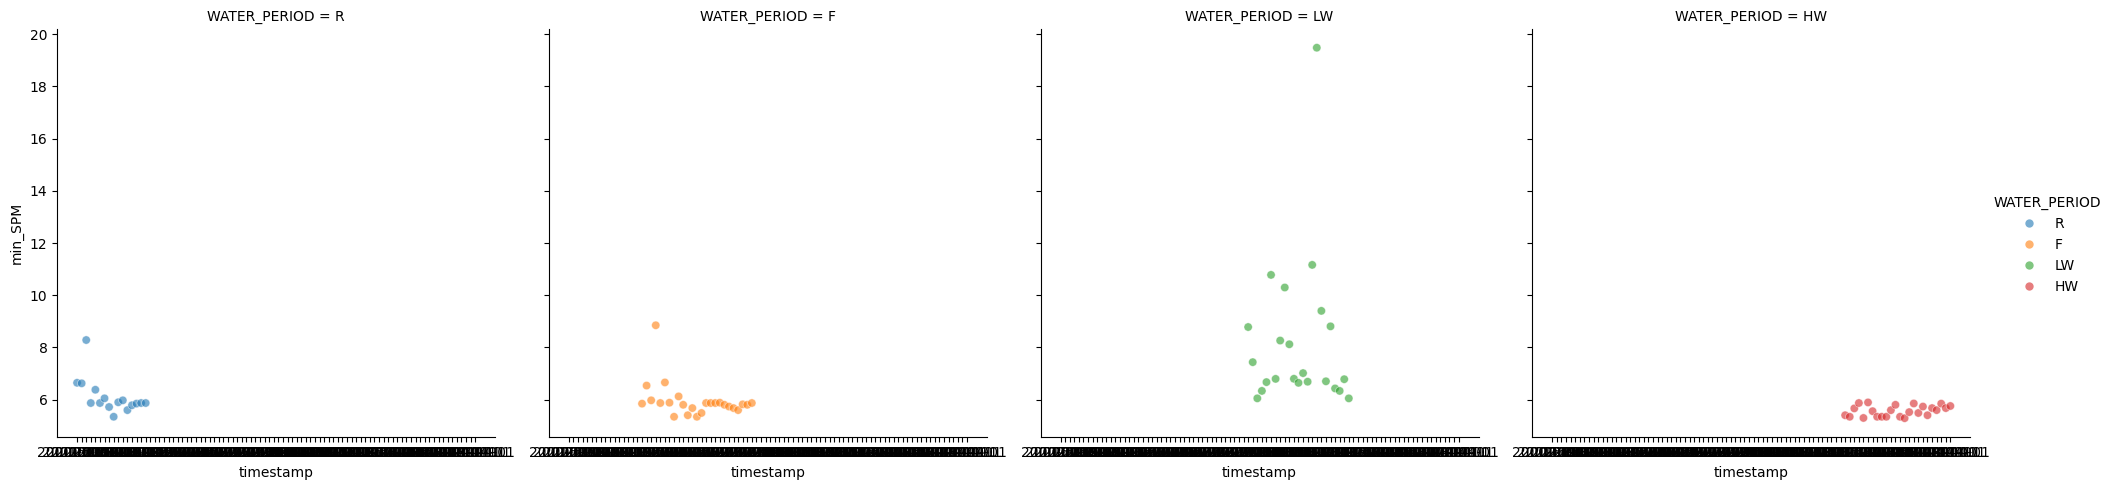

In [ ]:
sns.relplot(data=dfArea, x ='timestamp',y= 'min_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### std dev spm

<Axes: xlabel='timestamp', ylabel='stdDev_SPM'>

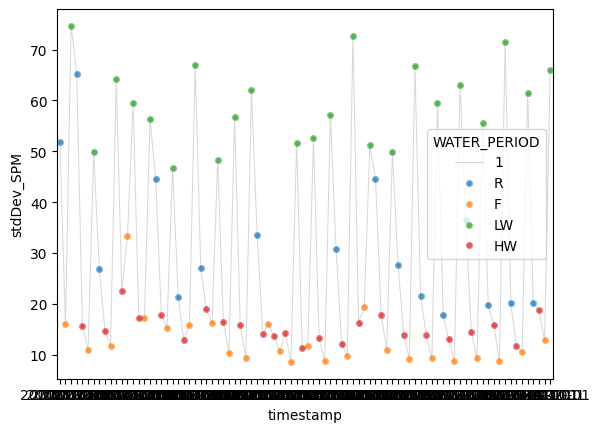

In [ ]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'stdDev_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'stdDev_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

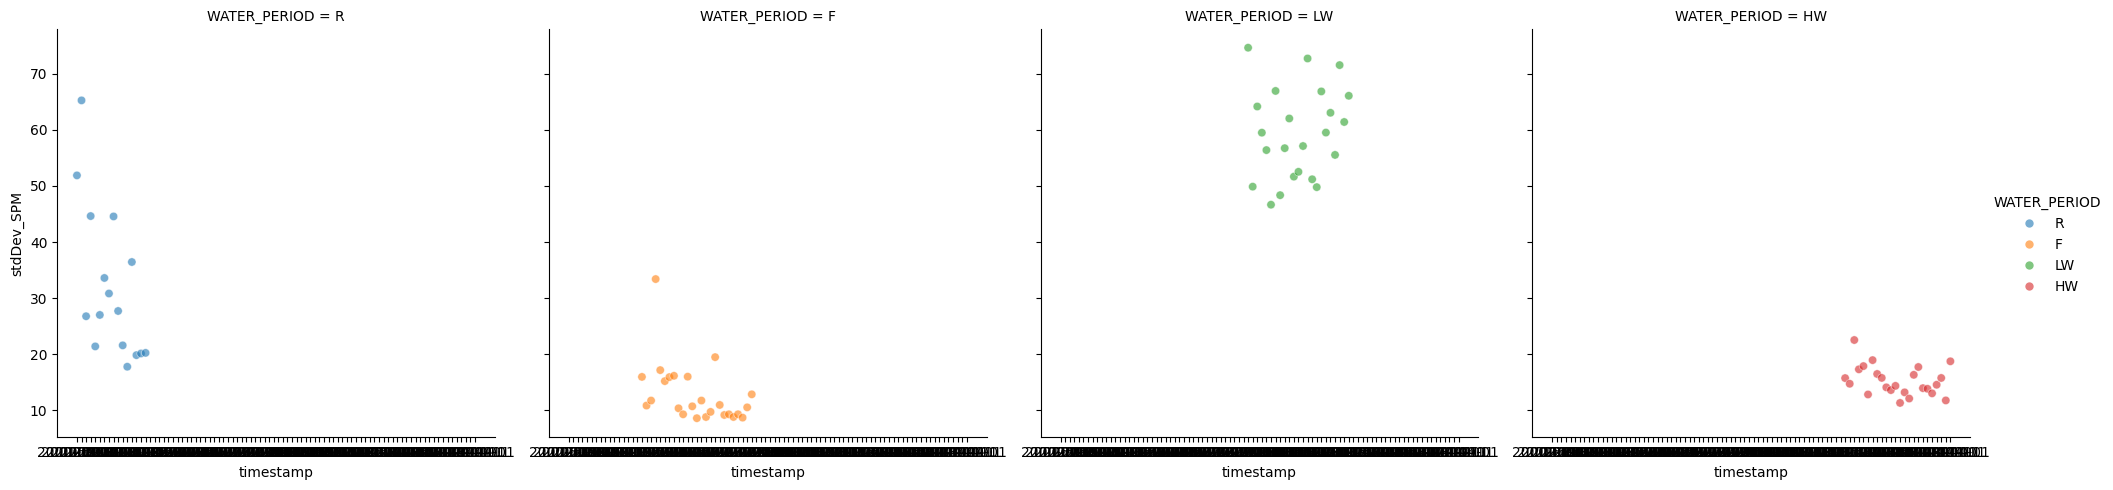

In [ ]:
sns.relplot(data=dfArea, x ='timestamp',y= 'stdDev_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

# Data vizualization

In [ ]:
dfArea.describe()

,area_km2,mean_SPM,max_SPM,min_SPM,stdDev_SPM,month_end,month_init,year
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,1212.133648,71.672432,275.593646,6.450083,29.088569,7.875000,5.875000,2012.375000
std,306.651157,67.829194,33.771140,1.855171,20.747571,3.194149,3.194149,7.463802
min,390.826379,18.263308,216.640869,5.287529,8.558269,3.000000,1.000000,2000.000000
25%,988.114911,23.139538,241.925220,5.672128,13.126836,6.000000,4.000000,2006.000000
50%,1325.063663,36.564975,282.928528,5.868872,17.799779,9.000000,7.000000,2013.000000
75%,1452.138795,95.231618,306.049042,6.628660,49.812609,12.000000,10.000000,2019.000000
max,1612.677713,211.574008,306.049042,19.483351,74.673074,12.000000,10.000000,2024.000000


<Axes: >

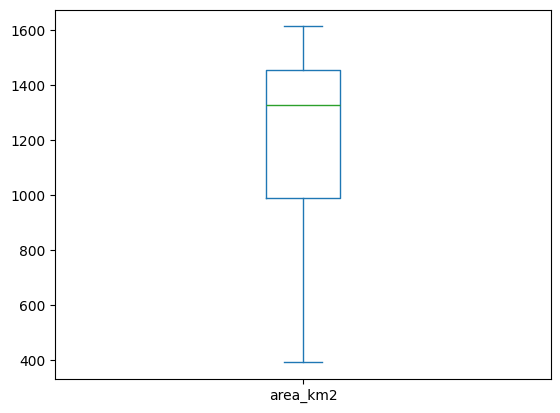

In [ ]:
dfArea['area_km2'].plot.box()

<Axes: >

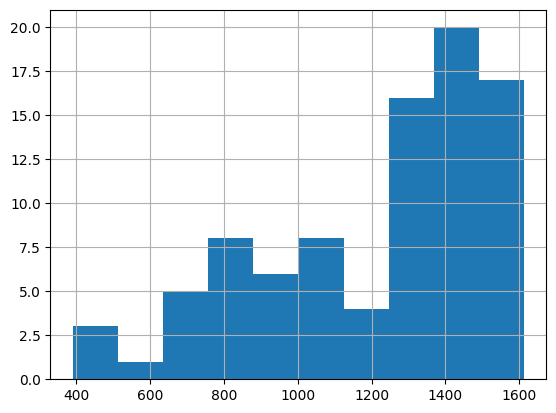

In [ ]:
dfArea['area_km2'].hist()

<Axes: >

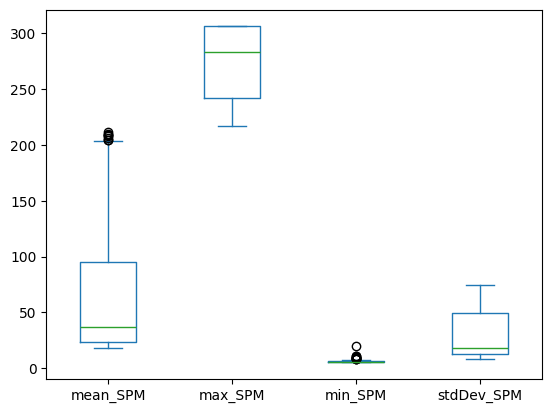

In [ ]:
dfArea[['mean_SPM','max_SPM','min_SPM','stdDev_SPM']].plot.box()

array([[<Axes: title={'center': 'mean_SPM'}>,
        <Axes: title={'center': 'max_SPM'}>],
       [<Axes: title={'center': 'min_SPM'}>,
        <Axes: title={'center': 'stdDev_SPM'}>]], dtype=object)

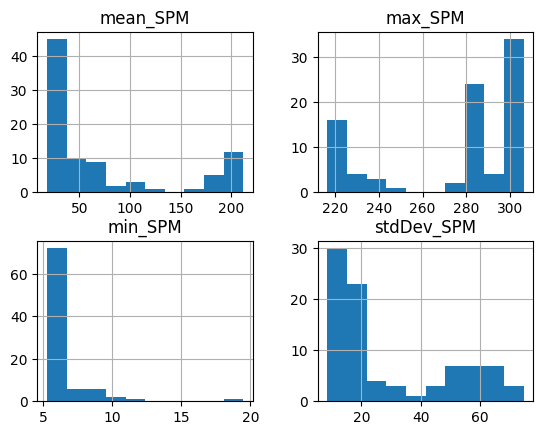

In [ ]:
dfArea[['mean_SPM','max_SPM','min_SPM','stdDev_SPM']].hist()

##Export results

In [ ]:
#export table results
dfArea.to_csv('/content/drive/MyDrive/CURUAI_PROCESS/area_SPM_time_series.csv')